## I had a last minute problem in the general pipeline. My HOG part stopped working and I couldn't figure out why.
## So, as a last result, I submit this notebook for my part (Oguzhan Sevim).

In [17]:
import cv2 as cv
import numpy as np
import os # this library provides easy access to the local file directories
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support, plot_confusion_matrix
from sklearn.svm import SVC

In [9]:
def HOG2(image, win_size, dummy=1):
    ## This function takes an RGB image as input. It calculates HOG features at each keypoint found by SIFT.
    max_kp = 500
    num_of_bins=30
    
    # Width and height of the image:
    im_h = image.shape[0]
    im_w = image.shape[1]
    
    # Find the coordinates of SIFT keypoints:
    sift = cv.SIFT_create()
    kp = sift.detect(image,None)
    kp = np.array([kp[i].pt for i in range(len(kp))])
    
    # IF there exists too many keypoints, select random max_kp of them.
    if kp.shape[0] > max_kp:
        idx = np.random.permutation(kp.shape[0])[0:max_kp]
        kp = kp[idx,:]
        
    # Convert the BGR to grayscale format:
    image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    
    # Calculate the gradients in x and y axis:
    Gradx = cv.Sobel(image,cv.CV_32F,1,0,ksize=3) # By using cv2.CV_32F, gradient of each pixel will be 32-bit floating numbers
    Grady = cv.Sobel(image,cv.CV_32F,0,1,ksize=3)
    
    # Find the angles between the gradients in radians:
    GradRadian = np.arctan2(Grady,Gradx) # Each element is between -3.14 and 3.14
    
    # Create an empty array for the descriptor with proper dimensions:
    hist = np.zeros((kp.shape[0] , num_of_bins))
    
    kp = np.rint(kp)
    
    for i in range(kp.shape[0]):
        kp_coor = kp[i,:]
        
        # Create a mask around the keypoint i:
        mask = np.zeros(image.shape, np.uint8)
        mask[int( np.max((kp_coor[1]-win_size,0)) ) : int( np.min((kp_coor[1]+win_size+1,im_h)) ) ,
             int( np.max((kp_coor[0]-win_size,0)) ) : int( np.min((kp_coor[0]+win_size+1,im_w)) ) ] = 1
        
        # Find the histogram of gradients for the window around keypoint i:
        hist_window = cv.calcHist([GradRadian],[0],mask,[num_of_bins],[-np.pi,np.pi])
        hist_window = hist_window / np.sum(np.abs(hist_window)) # Divide the histogram array by its L1 norm, so it adds up to 1.

        # Add the histogram of current cell to the overall descriptor matrix:
        hist[i,:] = hist_window[:,0]

    return kp, hist

In [10]:
# Read the training data:
def read_train(window_size):
    train_dir = 'Caltech20_v1/training'
    
    y_11 = [] # We will collect the labels of dataset in this list
    X_11 = [] # This will be our dataset

    descs = []

    # Keep class names in and corresponding label in this dic.
    classNameDic = {}

    for cls, class_name in enumerate(os.listdir(train_dir)):
        classNameDic.update({class_name : cls})
        print('Class name:', class_name)

        class_dir = train_dir+'/'+class_name
        for im_name in os.listdir(class_dir):

            # Save the class label of the image:
            y_11.append(cls)

            # Read the image as a (x,y,3) numpy array:
            image = cv.imread(class_dir+'/'+im_name)

            # Find the HOG of the image:
            _, histogram = HOG2(image, window_size, None)

            X_11.append(list(histogram))
            descs = descs + list(histogram)

    descs = np.array(descs)
    y_11 = np.array(y_11)
    
    return X_11, y_11, descs, classNameDic

In [11]:
# Read the test data:
def read_test(window_size, classNameDic):
    test_dir = 'Caltech20_v1/testing'

    y_11 = [] # We will collect the labels of dataset in this list
    X_11 = [] # This will be our dataset

    for class_name in os.listdir(test_dir):

        cls = classNameDic[class_name]
        class_dir = test_dir+'/'+class_name
        for im_name in os.listdir(class_dir):

            # Save the class label of the image:
            y_11.append(cls)

            # Read the image as a (x,y,3) numpy array:
            image = cv.imread(class_dir+'/'+im_name)

            # Find the HOG of the image:
            _, histogram = HOG2(image, window_size, None)

            X_11.append(list(histogram))

    y_11 = np.array(y_11)
    return X_11, y_11

In [12]:
# Form the clusters:
def cluster_function(n_clusters, descs):
    kmeans = KMeans(n_clusters=n_clusters, n_init=2, max_iter=50, random_state=0).fit(descs)
    return kmeans

def quantizer(kmeans, X, n_clusters):
    features = []
    for i in range(len(X)):
        clust_assigns = kmeans.predict(X[i])
        feature = np.histogram(clust_assigns, np.arange(n_clusters+1))
        features.append(list(feature[0]))

    X = np.array(features)
    X = X / np.sum(np.abs(X) , axis=1).reshape((X.shape[0],1))
    return X

In [13]:
def KfoldSVM(X_11,y_11,X_test_11,y_test_11,kf,c,k):
    mean_accuracy = 0
    for train_index, cv_index in kf.split(X_11, y_11):
        X_train, X_cv = X_11[train_index], X_11[cv_index]
        y_train, y_cv = y_11[train_index], y_11[cv_index]
    
        model = SVC(C=c, kernel='linear', class_weight='balanced')
        model.fit(X_train, y_train)
        fold_accuracy = model.score(X_cv, y_cv)
        mean_accuracy += fold_accuracy
        
    model = SVC(C=c, kernel='linear', class_weight='balanced')
    model.fit(X_11, y_11)
    test_accuracy = model.score(X_test_11, y_test_11)
    return mean_accuracy / k , test_accuracy

In [14]:
# Read the training and test data:
X_first, y, descs, classNameDic = read_train(12)
X_test_first, y_test = read_test(12, classNameDic)
print('Data is read')

# Find the dictionary and quantize the features:
kmeans = cluster_function(275, descs)
print('Dictionary is found')
X = quantizer(kmeans, X_first, 275)
X_test = quantizer(kmeans, X_test_first, 275)
print('Data is quantized')

# Build the SVM model and train it:
model = SVC(C=300, kernel='linear', class_weight='balanced')
model.fit(X, y)

# Predict the test labels:
y_predict = model.predict(X_test)

# Find the required evaluation metrics:
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_predict)
MeanF1 = np.mean(F1)
conf_matrix = multilabel_confusion_matrix(y_test, y_predict)
accuracy = 100 * np.sum(y_predict == y_test) / y_test.shape[0]

# Print the metrics:
print("MeanF1:", MeanF1)
print("precision:", precision)
print("recall:",recall)
print("F1:", F1)
print("conf_matrix:", conf_matrix)
print("accuracy:", accuracy)

plot_confusion_matrix(model, X_test, y_test)
plt.show()

Class name: airplanes
Class name: anchor
Class name: background_class
Class name: barrel
Class name: camera
Class name: car_side
Class name: dalmatian
Class name: Faces
Class name: ferry
Class name: headphone
Class name: lamp
Class name: pizza
Class name: pyramid
Class name: snoopy
Class name: soccer_ball
Class name: stop_sign
Class name: strawberry
Class name: sunflower
Class name: water_lilly
Class name: windsor_chair
Class name: yin_yang
Data is read
Dictionary is found
Data is quantized


NameError: name 'precision_recall_fscore_support' is not defined

MeanF1: 0.4612430308419902
precision: [0.74074074 0.28571429 0.         0.71428571 0.6        0.82608696
 0.6        0.58064516 1.         0.3        0.11111111 0.625
 0.7        0.5        0.         1.         0.33333333 0.71428571
 0.37037037 0.88235294 0.5       ]
recall: [1.   0.5  0.   0.25 0.15 0.95 0.45 0.9  0.55 0.3  0.05 0.5  0.35 0.65
 0.   0.6  0.25 0.5  0.5  0.75 0.15]
F1: [0.85106383 0.36363636 0.         0.37037037 0.24       0.88372093
 0.51428571 0.70588235 0.70967742 0.3        0.06896552 0.55555556
 0.46666667 0.56521739 0.         0.75       0.28571429 0.58823529
 0.42553191 0.81081081 0.23076923]
conf_matrix: [[[353   7]
  [  0  20]]

 [[335  25]
  [ 10  10]]

 [[337  43]
  [  0   0]]

 [[358   2]
  [ 15   5]]

 [[358   2]
  [ 17   3]]

 [[356   4]
  [  1  19]]

 [[354   6]
  [ 11   9]]

 [[347  13]
  [  2  18]]

 [[360   0]
  [  9  11]]

 [[346  14]
  [ 14   6]]

 [[352   8]
  [ 19   1]]

 [[354   6]
  [ 10  10]]

 [[357   3]
  [ 13   7]]

 [[347  13]
  [  7  13]]

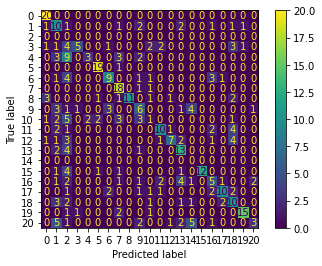

In [18]:
# Find the required evaluation metrics:
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_predict)
MeanF1 = np.mean(F1)
conf_matrix = multilabel_confusion_matrix(y_test, y_predict)
accuracy = 100 * np.sum(y_predict == y_test) / y_test.shape[0]

# Print the metrics:
print("MeanF1:", MeanF1)
print("precision:", precision)
print("recall:",recall)
print("F1:", F1)
print("accuracy:", accuracy)

plot_confusion_matrix(model, X_test, y_test)
plt.show()

In [ ]:
# This part is only for finding 5-fold CV accuracies:
windows = [12]
clusters = [100, 125, 150, 175, 200, 225, 250, 275]
C_values = [100, 150, 200, 250, 300, 350, 400, 450, 500]

cv_scores = np.zeros(( len(windows), len(clusters), len(C_values) ))
test_scores = np.zeros(( len(windows), len(clusters), len(C_values) ))

for w, win_size in enumerate(windows):
    X_first, y, descs, classNameDic = read_train(win_size)
    X_test_first, y_test = read_test(win_size, classNameDic)
    
    for cl, clust in enumerate(clusters):
        kmeans = cluster_function(clust, descs)
        X = quantizer(kmeans, X_first, clust)
        X_test = quantizer(kmeans, X_test_first, clust)
        
        for c_num, c in enumerate(C_values):
            print(win_size, clust, c)
            number_of_folds = 5 # Choose the number of folds for Cross Validation
            kf = StratifiedKFold(n_splits=number_of_folds, random_state=1, shuffle=True)
            
            cv_scores[w,cl,c_num], test_scores[w,cl,c_num] = KfoldSVM(X,y,X_test,y_test,kf,c,number_of_folds)
            
print(cv_scores[0,:,:])